In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [6]:
# ======== 1. Đọc và xử lý dữ liệu ========
df = pd.read_csv('Gold_Futures_Cleaned.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])
df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.dropna()
print(df.head()) 


# data = df[['Date', 'Price']].copy()

# # Chia 80% train, 20% test theo thời gian (lùi 60 bước cho test)
# split_index = int(len(data) * 0.8)
# train_data = data[:split_index]
# test_data = data[split_index - 60:]

# Chuẩn hóa
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(df[['Price']])
price_data = price_scaled.flatten()

# Thiết lập tham số thời gian
time_step = 60 

# Tạo chuỗi thời gian
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        # Lấy đoạn time_step giá trị liên tiếp làm đầu vào X
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        # Giá trị tiếp theo làm đầu ra Y
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

train_size = int(len(price_data) * 0.8)
test_size = len(price_data) - train_size
train_data = price_data[0:train_size]
test_data = price_data[train_size:len(price_data)]

# Tạo dataset cho train và test
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape đầu vào cho GRU [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

train_dates_for_plot = df.index[time_step : train_size]
test_dates_for_plot = df.index[train_size + time_step : ] 

# # Ngày tương ứng để vẽ
# train_dates = train_data['Date'].iloc[seq_length:].reset_index(drop=True)
# test_dates = test_data['Date'].iloc[seq_length:].reset_index(drop=True)

             Price    Open    High     Low
Date                                      
2010-01-04  1118.3  1099.0  1124.6  1093.8
2010-01-05  1118.7  1122.0  1129.6  1115.5
2010-01-06  1136.5  1118.5  1141.0  1116.8
2010-01-07  1133.7  1139.0  1139.5  1128.7
2010-01-08  1138.9  1131.5  1140.0  1119.5
X_train shape: (3072, 60, 1), y_train shape: (3072,)
X_test shape: (723, 60, 1), y_test shape: (723,)


In [7]:
# ======== 2. Xây dựng mô hình GRU ========
model = Sequential()
model.add(GRU(64, return_sequences=False, input_shape=(time_step, 1),
                kernel_regularizer=regularizers.l2(0.001))) # Thêm L2 regularization

model.add(Dropout(0.2))  # Thêm Dropout để giảm overfit
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\admin\anaconda3\envs\gru-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# ======== 3. Callbacks để giảm overfit ========
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

In [9]:
# ======== 4. Huấn luyện mô hình ========
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=1,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
2451/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 1: val_loss improved from inf to 0.00091, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0022 - val_loss: 9.0893e-04 - learning_rate: 0.0010
Epoch 2/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3685e-04
Epoch 2: val_loss improved from 0.00091 to 0.00034, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.3681e-04 - val_loss: 3.4488e-04 - learning_rate: 0.0010
Epoch 3/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6098e-04
Epoch 3: val_loss improved from 0.00034 to 0.00021, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 3.6095e-04 - val_loss: 2.1415e-04 - learning_rate: 0.0010
Epoch 4/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2074e-04
Epoch 4: val_loss did not improve from 0.00021
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 3.2072e-04 - val_loss: 4.4375e-04 - learning_rate: 0.0010
Epoch 5/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8854e-04
Epoch 5: val_loss did not improve from 0.00021
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.8856e-04 - val_loss: 2.8970e-04 - learning_rate: 0.0010
Epoch 6/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1284e-04
Epoch 6: val_loss did not improve from 0.00021
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 3.1281e-04 - val_loss: 5.7690e-04 - learning_rate: 0.0010
Epoch 7/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8284e-04
Epoch 7: val_loss did not improve from 0.00021
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.8285e-04 - val_l

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.9126e-04 - val_loss: 2.0554e-04 - learning_rate: 0.0010
Epoch 9/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7424e-04
Epoch 9: val_loss did not improve from 0.00021
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.7424e-04 - val_loss: 3.9360e-04 - learning_rate: 0.0010
Epoch 10/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2852e-04
Epoch 10: val_loss improved from 0.00021 to 0.00018, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.2852e-04 - val_loss: 1.7560e-04 - learning_rate: 0.0010
Epoch 11/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5225e-04
Epoch 11: val_loss improved from 0.00018 to 0.00017, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.5223e-04 - val_loss: 1.7441e-04 - learning_rate: 0.0010
Epoch 12/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3787e-04
Epoch 12: val_loss did not improve from 0.00017
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 2.3787e-04 - val_loss: 6.1959e-04 - learning_rate: 0.0010
Epoch 13/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2785e-04
Epoch 13: val_loss did not improve from 0.00017

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - loss: 2.2785e-04 - val_loss: 3.9536e-04 - learning_rate: 0.0010
Epoch 14/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8885e-04
Epoch 14: val_loss improved from 0.00017 to 0.00017, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 1.8884e-04 - val_loss: 1.6633e-04 - learning_rate: 5.0000e-04
Epoch 15/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9055e-04
Epoch 15: val_loss did not improve from 0.00017
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 1.9054e-04 - val_loss: 3.3951e-04 - learning_rate: 5.0000e-04
Epoch 16/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7320e-04
Epoch 16: val_loss did not improve from 0.00017
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 1.7320e-04 - val_loss: 1.8586e-04 - learning_rate: 5.0000e-04
Epoch 17/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6411e-04
Epoch 17: val_loss did not improve from 0.00017
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 1.6411e-04 - val_loss: 2.0264e-04 - learning_rate: 5.0000e-04
Epoch 18/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6835e-04
Epoch 18: val_loss did not improve from 0.00017
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 1.5865e-04 - val_loss: 1.4528e-04 - learning_rate: 5.0000e-04
Epoch 21/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4487e-04
Epoch 21: val_loss improved from 0.00015 to 0.00013, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 1.4488e-04 - val_loss: 1.2861e-04 - learning_rate: 5.0000e-04
Epoch 22/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5655e-04
Epoch 22: val_loss did not improve from 0.00013
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 1.5655e-04 - val_loss: 1.3990e-04 - learning_rate: 5.0000e-04
Epoch 23/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5259e-04
Epoch 23: val_loss did not improve from 0.00013

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 1.5259e-04 - val_loss: 1.3219e-04 - learning_rate: 5.0000e-04
Epoch 24/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3147e-04
Epoch 24: val_loss did not improve from 0.00013
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 1.3147e-04 - val_loss: 3.6196e-04 - learning_rate: 2.5000e-04
Epoch 25/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3364e-04
Epoch 25: val_

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 1.1249e-04 - val_loss: 1.2672e-04 - learning_rate: 2.5000e-04
Epoch 28/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2916e-04
Epoch 28: val_loss did not improve from 0.00013
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 1.2916e-04 - val_loss: 2.1467e-04 - learning_rate: 2.5000e-04
Epoch 29/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1719e-04
Epoch 29: val_loss improved from 0.00013 to 0.00012, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 1.1719e-04 - val_loss: 1.2255e-04 - learning_rate: 2.5000e-04
Epoch 30/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1826e-04
Epoch 30: val_loss improved from 0.00012 to 0.00012, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 1.1826e-04 - val_loss: 1.1760e-04 - learning_rate: 2.5000e-04
Epoch 31/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3089e-04
Epoch 31: val_loss did not improve from 0.00012
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 1.3089e-04 - val_loss: 1.2984e-04 - learning_rate: 2.5000e-04
Epoch 32/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2568e-04
Epoch 32: val_loss did not improve from 0.00012
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 1.2568e-04 - val_loss: 1.4820e-04 - learning_rate: 2.5000e-04
Epoch 33/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2709e-04
Epoch 33: val_loss improved from 0.00012 to 0.00012, saving model to best_model.h5



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 1.2708e-04 - val_loss: 1.1655e-04 - learning_rate: 2.5000e-04
Epoch 34/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0540e-04
Epoch 34: val_loss did not improve from 0.00012
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 1.0541e-04 - val_loss: 1.6780e-04 - learning_rate: 1.2500e-04
Epoch 35/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0436e-04
Epoch 35: val_loss improved from 0.00012 to 0.00012, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 1.0436e-04 - val_loss: 1.1638e-04 - learning_rate: 1.2500e-04
Epoch 36/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9511e-05
Epoch 36: val_loss did not improve from 0.00012
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 9.9524e-05 - val_loss: 1.2073e-04 - learning_rate: 1.2500e-04
Epoch 37/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0799e-04
Epoch 37: val_loss did not improve from 0.00012
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 1.0799e-04 - val_loss: 2.2435e-04 - learning_rate: 1.2500e-04
Epoch 38/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0289e-04
Epoch 38: val_loss did not improve from 0.00012
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - loss: 1.0289e-04 - val_loss: 1.2212e-04 - learning_rate: 1.2500e-04
Epoch 39/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.8443e-05
Epoch 39: val_loss did not improve from 0.00012
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 9.8705e-05 - val_loss: 1.1255e-04 - learning_rate: 6.2500e-05
Epoch 48/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2017e-05
Epoch 48: val_loss improved from 0.00011 to 0.00011, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 9.2015e-05 - val_loss: 1.1220e-04 - learning_rate: 6.2500e-05
Epoch 49/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3315e-05
Epoch 49: val_loss improved from 0.00011 to 0.00011, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 9.3326e-05 - val_loss: 1.1135e-04 - learning_rate: 6.2500e-05
Epoch 50/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2738e-05
Epoch 50: val_loss did not improve from 0.00011
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 9.2748e-05 - val_loss: 1.1378e-04 - learning_rate: 6.2500e-05
Epoch 51/100
2451/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1389e-05
Epoch 51: val_loss improved from 0.00011 to 0.00011, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 9.1388e-05 - val_loss: 1.0935e-04 - learning_rate: 6.2500e-05
Epoch 52/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4161e-05
Epoch 52: val_loss did not improve from 0.00011
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 9.4158e-05 - val_loss: 1.0935e-04 - learning_rate: 6.2500e-05
Epoch 53/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0946e-05
Epoch 53: val_loss did not improve from 0.00011
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 9.0952e-05 - val_loss: 1.0987e-04 - learning_rate: 6.2500e-05
Epoch 54/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2392e-05
Epoch 54: val_loss did not improve from 0.00011
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 9.2394e-05 - val_loss: 1.1505e-04 - learning_rate: 6.2500e-05
Epoch 55/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.6863e-05
Epoch 55: val_loss did not improve from 0.00011
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - l

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 8.0091e-05 - val_loss: 1.0849e-04 - learning_rate: 1.5625e-05
Epoch 77/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.1276e-05
Epoch 77: val_loss did not improve from 0.00011

Epoch 77: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 9.1275e-05 - val_loss: 1.1234e-04 - learning_rate: 1.5625e-05
Epoch 78/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.2714e-05
Epoch 78: val_loss did not improve from 0.00011
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - loss: 8.2715e-05 - val_loss: 1.0884e-04 - learning_rate: 7.8125e-06
Epoch 79/100
2451/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5848e-05
Epoch 79: val_loss did not improve from 0.00011
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 8.5849e-05 - val_loss: 1.0857e-04 - learning_rate: 7.8125e-06
Epoch 80/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1471e-05
Epoch 80: val_

In [10]:
# ======== 5. Dự đoán ========
y_pred = model.predict(X_test)
# y_test_inv = scaler.inverse_transform(y_test)
# y_pred_inv = scaler.inverse_transform(y_pred)
# train_inv = scaler.inverse_transform(y_train)
dummy_test_data = np.zeros(shape=(len(y_test), scaler.n_features_in_))
dummy_test_data[:,0] = y_test.flatten()
y_test_inv = scaler.inverse_transform(dummy_test_data)[:,0]

dummy_pred_data = np.zeros(shape=(len(y_pred), scaler.n_features_in_))
dummy_pred_data[:,0] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(dummy_pred_data)[:,0]

dummy_train_data = np.zeros(shape=(len(y_train), scaler.n_features_in_))
dummy_train_data[:,0] = y_train.flatten()
train_inv = scaler.inverse_transform(dummy_train_data)[:,0]



23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [11]:
# ======== 6. Đánh giá ========
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2 Score:", r2)

MAE: 21.83836029382162
MAPE: 0.9360410246138811
RMSE: 30.979359000115
R2 Score: 0.9947485143106005


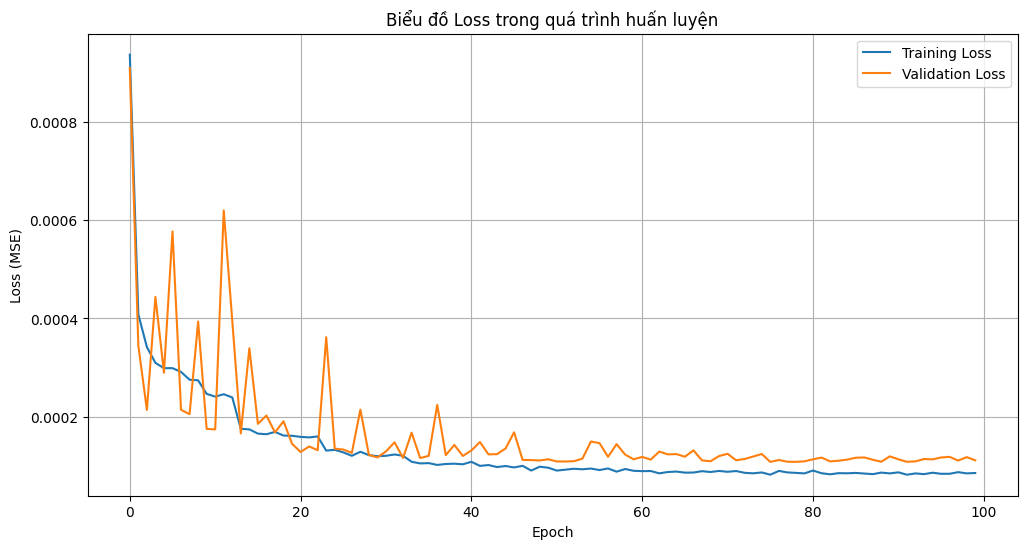

In [12]:
# ======== 7. Vẽ biểu đồ Loss ========
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Biểu đồ Loss trong quá trình huấn luyện')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

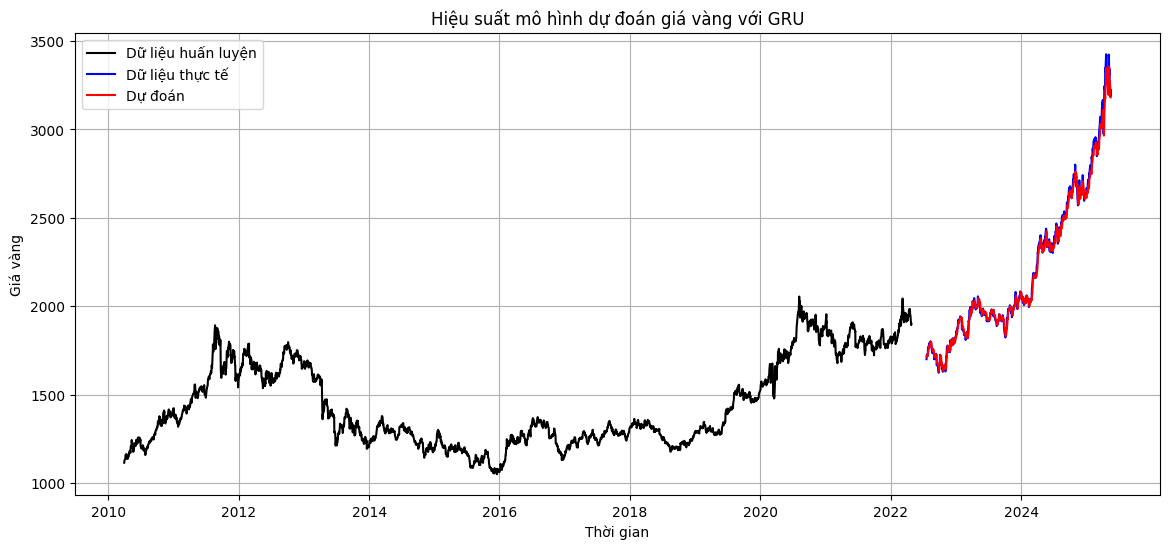

In [13]:
# ======== 8. Vẽ biểu đồ dự đoán ========
plt.figure(figsize=(14, 6))
plt.plot(train_dates_for_plot, train_inv, label='Dữ liệu huấn luyện', color='black') # Sử dụng train_dates_for_plot mới
plt.plot(test_dates_for_plot, y_test_inv, label='Dữ liệu thực tế', color='blue')   # Sử dụng test_dates_for_plot mới
plt.plot(test_dates_for_plot, y_pred_inv, label='Dự đoán', color='red')
plt.title('Hiệu suất mô hình dự đoán giá vàng với GRU')
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng')
plt.legend()
plt.grid()

years = pd.to_datetime([f'{y}-01-01' for y in range(2010, 2026, 2)])
plt.xticks(ticks=years, labels=[str(y.year) for y in years])
plt.show()